In [1]:
import pandas as pd
import numpy as np
import random
import multiprocessing
import json
from queue import Queue
from collections import defaultdict
import heapq

import networkx as nx
import matplotlib.pyplot as plt

from tqdm import tqdm

from generators import scalefreegen as sfg

In [2]:
# MSG structure: [ msg_id, timestamp, author_id, parent_author_id, parent_msg_id ] 
F_MSG_ID = 0
F_MSG_TIME = 1
F_MSG_AUTH = 2
F_MSG_PRN_AUTH = 3
F_MSG_PRN_MSG = 4
U_MSG_SIZE = 5

In [3]:
def SubsetList(data_list, index_list, flatten = False):
    if flatten:
        return [item for i in index_list for item in data_list[i]]
    else:
        return [data_list[i] for i in index_list]


def RussTweets(x_test):
    return (7.283176e+01 -5.428544e+00*x_test+  9.429966e-02*x_test**2-5.146635e-04*x_test**3+1.342797e-06 *x_test**4-1.889452e-09*x_test**5+1.470335e-12*x_test**6-5.963228e-16*x_test**7+ 9.849229e-20 *x_test**8)/100

def WestTweets(x_test):
    # return np.random.rand()
    return (8.523689e+01 +1.920699e+00*x_test+   2.923480e-02*x_test**2 -2.568334e-04*x_test**3+7.671775e-07 *x_test**4-1.139749e-09*x_test**5+9.108272e-13*x_test**6-3.752358e-16*x_test**7+ 6.265970e-20 *x_test**8)/200

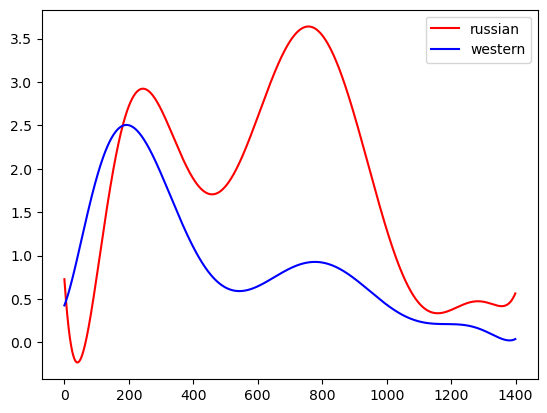

In [4]:
pd.Series([RussTweets(t) for t in range(1400)]).plot(label="russian",c="red")
pd.Series([WestTweets(t) for t in range(1400)]).plot(label="western",c="blue")
plt.legend()
plt.show()

In [5]:
class DoiSim:
    def __init__(self, num_nodes = 600, wall_size = 50, net_beta = 0.95):
        # Parameters:
        self.num_nodes = num_nodes
        self.network_beta = net_beta
        self.wall_size = wall_size
        self.delta_in = 0.1
        self.delta_out = 0.1
        self.RemovedAuthors = set()
        # Dynamically generated attributes:
        # -- Generated Before simulation --
        self.InNeighbors = None
        self.ImitationRatio = None
        self.ImitationRate = None
        self.InnovationRate = None
        self.num_russ_nodes = self.num_nodes // 3
        # -- Generated After simulation --
        self.MSG_NEXT_ID = 0
        self.UserMentions = None # current readable history for users
        self.AllMentions = None # all history of tweets
        # -- analytics --
        self.run_analytics = {"overload": 0, "not-overload": 0, "ovd_rt": [], "nonovd_rt": [], "tweets": []}
        
    def _CreateNetwork(self):
        self.num_russ_nodes = self.num_nodes // 3
        self.west_nodes = self.num_nodes - self.num_russ_nodes
        n1 = sfg.GenerateScaleFreeNetworkByBeta(self.num_russ_nodes, 0.95, self.delta_in, self.delta_out)
        n2 = sfg.GenerateScaleFreeNetworkByBeta(self.west_nodes, 0.95, self.delta_in, self.delta_out)
        n3 = {"edges": np.random.binomial(1, 0.1, (self.num_russ_nodes,self.west_nodes))}
        n4 = {"edges": np.random.binomial(1, 0.1, (self.west_nodes,self.num_russ_nodes))}
        node_to_in_link_neighbors = {}
        node_in_link_probability = {}
        def addAdjList(src, dst):
            if dst in node_to_in_link_neighbors:
                node_to_in_link_neighbors[dst].append(src)
            else:
                node_to_in_link_neighbors[dst] = [src]
        net_edges = np.block([[n1["edges"],n3["edges"]],[n4["edges"],n2["edges"]]])
        for src in range(self.num_nodes):
            for dst in range(self.num_nodes):
                if net_edges[src,dst] != 0:
                    addAdjList(src, dst)
                    node_in_link_probability[(src, dst)] = np.random.uniform(0.5, 1.0) # random value in range (0 , 1]
        self.InNeighbors = {k:np.array(node_to_in_link_neighbors[k]) for k in node_to_in_link_neighbors}
        self.ImitationRatio = node_in_link_probability
        return
    
    def CreateSim(self):
        self._CreateNetwork()
        # self.InnovationRate = np.random.uniform(0, 0.1, size=(self.num_nodes, 24)) # 0 < p <= 0.01
        self.InnovationRate = pd.read_csv("innovation_rates.csv").sample(self.num_nodes, axis=1).T.values
        self.ImitationRate = pd.read_csv("imition_rates.csv").sample(self.num_nodes, axis=1).T.values
        self.Initialize()
        return

    def Initialize(self):
        self.MSG_NEXT_ID = 0
        self.UserMentions = [[] for u in range(self.num_nodes)]
        self.AllMentions = []

    """ Run the simulation """
    def Run(self, in_max_steps):
        for step in tqdm(range(in_max_steps)):
            
            NewUserMentions = [[] for u in range(self.num_nodes)]
            day = step // 24
            hour = step % 24
            # execute information processing by each user
            for user_idx in range(self.num_nodes):
                if user_idx not in self.RemovedAuthors:
                    NewUserMentions[user_idx] = self.ICM_Func(user_idx, step, day, hour)

            self.AllMentions.extend(NewUserMentions)
    
            # Copy the next state onto current state
            for user_idx in range(self.num_nodes):
                self.UserMentions[user_idx].extend(NewUserMentions[user_idx])
                if len(self.UserMentions[user_idx]) > self.wall_size:
                    self.UserMentions[user_idx] = self.UserMentions[user_idx][-self.wall_size:]

    """ ICM Model function """
    def ICM_Func(self, in_UserIdx, in_TimeStep, in_Day, in_Hour):
        out_NewUserMentions = []
        # Imitation
        neighborhood = self.InNeighbors[in_UserIdx] if in_UserIdx in self.InNeighbors else []
        # read follower neighborhood walls
        messages = SubsetList(self.UserMentions, neighborhood, True)
        if len(messages) > 30: 
            self.run_analytics["overload"] += 1
            # information overloaded : select from favored subset of users
            overload = len(messages) - 30
            num_retweets = max(1, 30 - int(overload ** 0.1))
            # lam = (self.ImitationRate[in_UserIdx, in_Hour] * len(messages)) ** -3
            # num_retweets = np.random.poisson(lam) # driven by rate of imitaiton
            self.run_analytics["ovd_rt"].append((overload, num_retweets))
            if num_retweets > 0:
                messages = heapq.nlargest(num_retweets, messages, key=lambda x: x[F_MSG_TIME])
                # pick pref_users based on Own History OR Uniformly Ranomly
                if len(self.UserMentions[in_UserIdx]) > 0:
                    local_msgs_idxs = np.random.choice(len(self.UserMentions[in_UserIdx]), size=num_retweets, replace=True)
                    pref_users = [msg[F_MSG_PRN_AUTH] for msg in SubsetList(self.UserMentions[in_UserIdx], local_msgs_idxs)] # get parentid
                    pref_messages = [msg for msg in messages if msg[F_MSG_AUTH] in pref_users]
                else:
                    pref_messages = messages
                # pref_messages = messages[np.isin(messages[:,F_MSG_AUTH], pref_users)] # msgs authored by pref_users
                local_msg_id = np.random.choice(len(pref_messages), size=min(len(pref_messages), num_retweets), replace=False) # select msgs to reply to
                msgs = SubsetList(pref_messages, local_msg_id)
                for msg in msgs:
                    new_msg_id = self.MSG_NEXT_ID
                    self.MSG_NEXT_ID += 1
                    new_msg = (new_msg_id, in_TimeStep, in_UserIdx, msg[F_MSG_AUTH], msg[F_MSG_ID])
                    out_NewUserMentions.append(new_msg)
        else:
            self.run_analytics["not-overload"] += 1
            # not overloaded : reply to each neighbor probabilistically
            author_data = defaultdict(list)
            for msg in messages:
                author_data[msg[F_MSG_AUTH]].append(msg)
                
            for auth,auth_msgs in author_data.items():
                count = len(auth_msgs)
                lam = self.ImitationRatio.get((auth, in_UserIdx), 0) * count
                num_retweets = np.random.poisson(lam)
                self.run_analytics["nonovd_rt"].append((lam, num_retweets))
                pref_msg_local_ids = np.random.choice(count, size=min(num_retweets,count), replace=False)
                pref_messages = SubsetList(auth_msgs, pref_msg_local_ids)
                for msg in pref_messages:
                    new_msg_id = self.MSG_NEXT_ID
                    self.MSG_NEXT_ID += 1
                    new_msg = (new_msg_id, in_TimeStep, in_UserIdx, msg[F_MSG_AUTH], msg[F_MSG_ID])
                    out_NewUserMentions.append(new_msg)
                # if len(pref_messages) > 0:
                #     print(pref_messages)
                #     print(out_NewUserMentions)
        # Innovation
        exo_effect = RussTweets(in_TimeStep) if in_UserIdx < self.num_russ_nodes else WestTweets(in_TimeStep)
        exo_effect = max(exo_effect, 0)
        lam = self.InnovationRate[in_UserIdx, in_Hour] + exo_effect 
        num_tweets = np.random.poisson(lam)
        self.run_analytics["tweets"].append((lam, num_tweets))
        for tweet_id in range(num_tweets):
            new_msg_id = self.MSG_NEXT_ID
            self.MSG_NEXT_ID += 1
            new_msg = (new_msg_id, in_TimeStep, in_UserIdx, -1, -1)
            out_NewUserMentions.append(new_msg)
        # print(out_NewUserMentions)
        random.shuffle(out_NewUserMentions)
        return out_NewUserMentions

    def SetRemovedAuthors(self, in_authors):
        self.RemovedAuthors = set(in_authors)

    def get_mentions(self):
        return pd.DataFrame([msg for wall in self.AllMentions for msg in wall], columns= [ "msg_id", "timestamp", "author_id", "parent_author_id", "parent_msg_id" ] )

    

In [6]:
dsim = DoiSim()
dsim.CreateSim()
dsim.num_russ_nodes, dsim.num_nodes - dsim.num_russ_nodes

(200, 400)

In [7]:
# Create an empty graph
G = nx.DiGraph()

# Add edges between nodes and their neighbors
for node, neighbors_list in dsim.InNeighbors.items():
    for neighbor in neighbors_list:
        G.add_edge(neighbor, node)


In [8]:
nx.write_gexf(G, "graph_01.gexf")

In [9]:
# Draw the graph
# plt.figure(figsize=(8, 6))
# nx.draw(G, with_labels=True, node_color='lightblue', node_size=10, font_size=8, font_weight='bold', edge_color='gray')
# plt.title("Network of Nodes and Their Neighbors")
# plt.show()

In [10]:
STEPS = 24 * 56
STEPS

1344

In [11]:
%%time
dsim.Run(STEPS)

dfout = dsim.get_mentions()
dfout

100%|██████████████████████████████████████████████████████████████████████████████| 1344/1344 [02:36<00:00,  8.59it/s]


CPU times: total: 1min 17s
Wall time: 2min 38s


,msg_id,timestamp,author_id,parent_author_id,parent_msg_id
0,0,0,0,-1,-1
1,2,0,2,-1,-1
2,1,0,2,-1,-1
3,3,0,4,-1,-1
4,4,0,5,-1,-1
...,...,...,...,...,...
4270404,4270404,1343,594,31,4266688
4270405,4270405,1343,594,31,4266685
4270406,4270400,1343,594,31,4266686
4270407,4270407,1343,597,0,4266623


In [12]:
dfout[dfout["parent_author_id"] != -1].shape[0] / dfout.shape[0]

0.7609819106319793

In [13]:
np.array([e[1] for e in dsim.run_analytics['ovd_rt']]).mean()

28.231257054798007

In [14]:
np.array([e[0] for e in dsim.run_analytics['ovd_rt']]).mean(), len(dsim.run_analytics['ovd_rt'])

(1915.0142629544407, 805303)

In [15]:
np.array([e[0] for e in dsim.run_analytics['nonovd_rt']]).mean(), len(dsim.run_analytics['nonovd_rt'])

(1.0005450504817872, 6745)

In [16]:
np.array([e[0] for e in dsim.run_analytics['tweets']]).mean(), len(dsim.run_analytics['tweets'])

(1.2653632832845145, 806400)

In [17]:
len(dsim.run_analytics['ovd_rt'])

805303

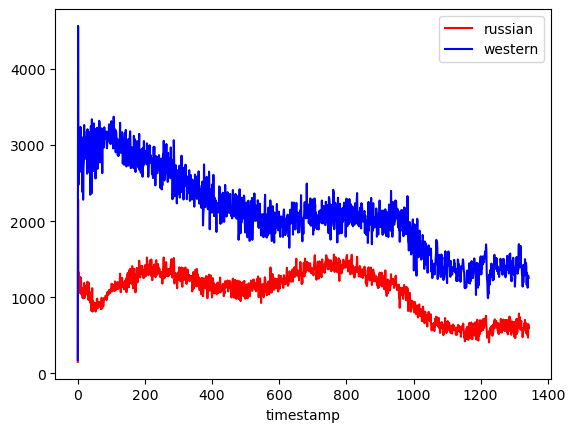

In [18]:
dfout[dfout["author_id"] < dsim.num_russ_nodes].groupby("timestamp").size().plot(label="russian",c="red")
dfout[dfout["author_id"] > dsim.num_russ_nodes].groupby("timestamp").size().plot(label="western",c="blue")
plt.legend()
plt.show()

<Axes: xlabel='timestamp'>

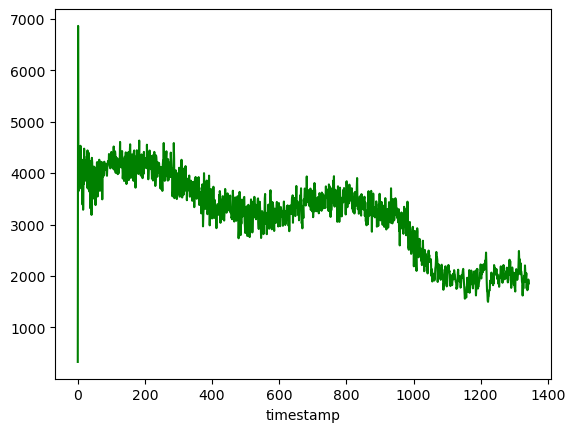

In [19]:
dfout.groupby("timestamp").size().plot(label="russian",c="green")

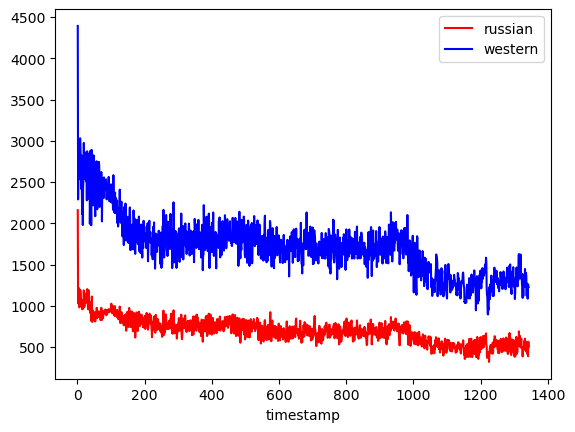

In [20]:
dfout[(dfout["author_id"] < dsim.num_russ_nodes) & (dfout["parent_author_id"] != -1)].groupby("timestamp").size().plot(label="russian",c="red")
dfout[(dfout["author_id"] > dsim.num_russ_nodes) & (dfout["parent_author_id"] != -1)].groupby("timestamp").size().plot(label="western",c="blue")
plt.legend()
# plt.ylim([0,3000])
plt.show()

In [21]:
NUM_PEOPLE = 60
inf_rr = set(dfout.groupby("author_id").size().sort_values(ascending=False).iloc[:NUM_PEOPLE].index)
dsim.Initialize()
dsim.SetRemovedAuthors(inf_rr)

In [22]:
print("Removed Russian: ", len({e for e in inf_rr if e < dsim.num_russ_nodes}) )
print("Removed Western: ", len({e for e in inf_rr if e >= dsim.num_russ_nodes}) )

Removed Russian:  27
Removed Western:  33


In [23]:
%%time
dsim.Run(STEPS)

dfout2 = dsim.get_mentions()
dfout2

100%|██████████████████████████████████████████████████████████████████████████████| 1344/1344 [02:11<00:00, 10.19it/s]


CPU times: total: 1min
Wall time: 2min 13s


,msg_id,timestamp,author_id,parent_author_id,parent_msg_id
0,0,0,2,-1,-1
1,1,0,4,-1,-1
2,2,0,4,-1,-1
3,3,0,5,-1,-1
4,4,0,9,-1,-1
...,...,...,...,...,...
3164841,3164843,1343,599,66,3162957
3164842,3164838,1343,599,66,3162961
3164843,3164841,1343,599,66,3162963
3164844,3164840,1343,599,66,3162962


<Axes: xlabel='timestamp'>

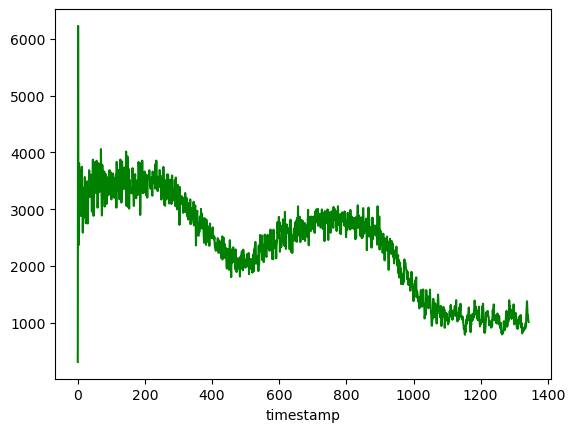

In [24]:
dfout2.groupby("timestamp").size().plot(label="russian",c="green")

In [25]:
inf_rus_rr = set(dfout[dfout["author_id"] < dsim.num_russ_nodes].groupby("author_id").size().sort_values(ascending=False).iloc[:NUM_PEOPLE].index)
dsim.Initialize()
dsim.SetRemovedAuthors(inf_rus_rr)
print("Removed Russian: ", len({e for e in inf_rus_rr if e < dsim.num_russ_nodes}) )
print("Removed Western: ", len({e for e in inf_rus_rr if e >= dsim.num_russ_nodes}) )

Removed Russian:  60
Removed Western:  0


In [26]:
%%time
dsim.Run(STEPS)

dfout3 = dsim.get_mentions()
dfout3

100%|██████████████████████████████████████████████████████████████████████████████| 1344/1344 [02:07<00:00, 10.56it/s]


CPU times: total: 46.6 s
Wall time: 2min 9s


,msg_id,timestamp,author_id,parent_author_id,parent_msg_id
0,0,0,0,-1,-1
1,1,0,3,-1,-1
2,2,0,3,-1,-1
3,4,0,4,-1,-1
4,3,0,4,-1,-1
...,...,...,...,...,...
2797166,2797166,1343,597,7,2794436
2797167,2797167,1343,597,7,2795807
2797168,2797163,1343,597,7,2794437
2797169,2797169,1343,599,3,2795156


In [27]:
inf_rts = set(dfout[dfout["parent_author_id"] != -1].groupby("parent_author_id").size().sort_values(ascending=False).iloc[:NUM_PEOPLE].index)
dsim.Initialize()
dsim.SetRemovedAuthors(inf_rts)
print("Removed Russian: ", len({e for e in inf_rts if e < dsim.num_russ_nodes}) )
print("Removed Western: ", len({e for e in inf_rts if e >= dsim.num_russ_nodes}) )

Removed Russian:  43
Removed Western:  17


In [28]:
%%time
dsim.Run(STEPS)

dfout4 = dsim.get_mentions()
dfout4

100%|██████████████████████████████████████████████████████████████████████████████| 1344/1344 [02:06<00:00, 10.63it/s]


CPU times: total: 51 s
Wall time: 2min 9s


,msg_id,timestamp,author_id,parent_author_id,parent_msg_id
0,0,0,1,-1,-1
1,1,0,3,-1,-1
2,2,0,6,-1,-1
3,4,0,16,-1,-1
4,3,0,16,-1,-1
...,...,...,...,...,...
5054659,5054656,1343,599,3,5048585
5054660,5054651,1343,599,3,5048591
5054661,5054644,1343,599,3,5048589
5054662,5054650,1343,599,3,5048590


In [29]:
inf_rts_rus = set(dfout[(dfout["parent_author_id"] != -1) & (dfout["parent_author_id"] < dsim.num_russ_nodes)].groupby("parent_author_id").size().sort_values(ascending=False).iloc[:NUM_PEOPLE].index)
dsim.Initialize()
dsim.SetRemovedAuthors(inf_rts_rus)
print("Removed Russian: ", len({e for e in inf_rts_rus if e < dsim.num_russ_nodes}) )
print("Removed Western: ", len({e for e in inf_rts_rus if e >= dsim.num_russ_nodes}) )

Removed Russian:  60
Removed Western:  0


In [30]:
%%time
dsim.Run(STEPS)

dfout5 = dsim.get_mentions()
dfout5

100%|██████████████████████████████████████████████████████████████████████████████| 1344/1344 [02:06<00:00, 10.63it/s]


CPU times: total: 47.4 s
Wall time: 2min 9s


,msg_id,timestamp,author_id,parent_author_id,parent_msg_id
0,0,0,1,-1,-1
1,2,0,3,-1,-1
2,1,0,3,-1,-1
3,3,0,9,-1,-1
4,4,0,10,-1,-1
...,...,...,...,...,...
4094003,4094004,1343,599,3,4089888
4094004,4093999,1343,599,3,4089886
4094005,4094001,1343,599,3,4089890
4094006,4094003,1343,599,3,4089891


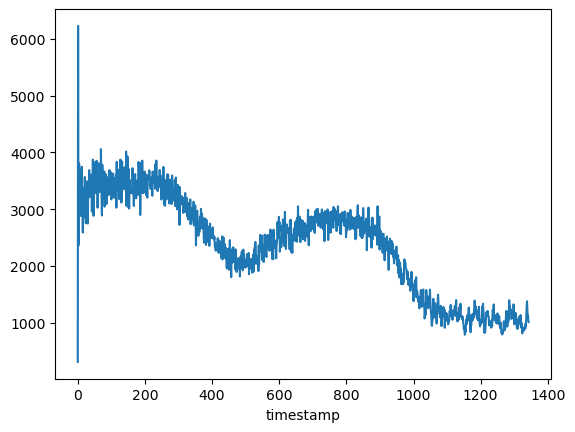

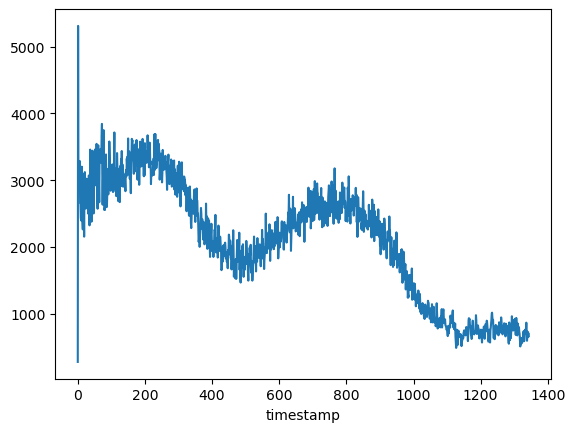

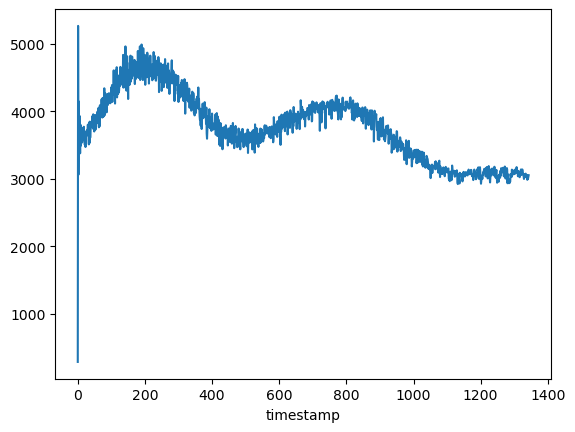

In [31]:
# dfout.groupby("timestamp").size().plot(label="all",c="red")
dfout2.groupby("timestamp").size().plot(label="global")
plt.show()
dfout3.groupby("timestamp").size().plot(label="russian")
plt.show()
dfout4.groupby("timestamp").size().plot(label="rts global")
plt.show()


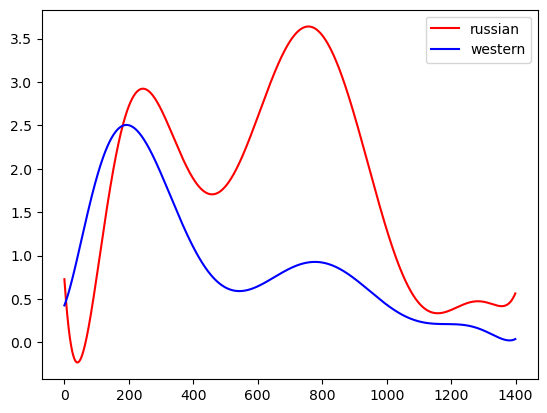

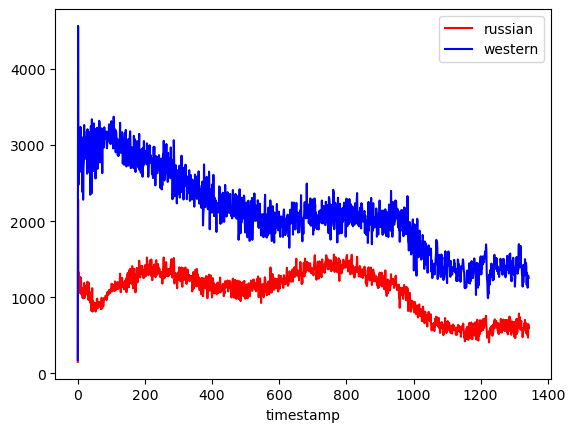

<Axes: xlabel='timestamp'>

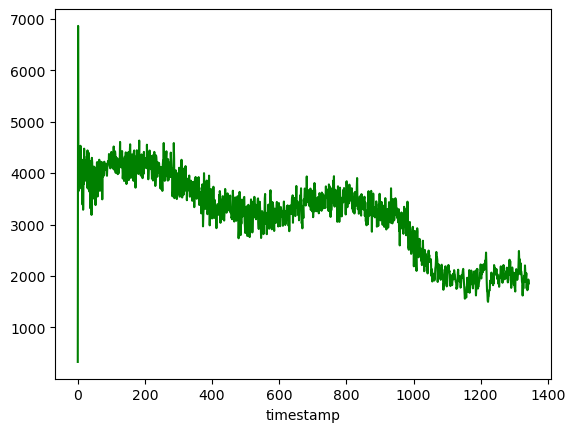

In [32]:
pd.Series([RussTweets(t) for t in range(1400)]).plot(label="russian",c="red")
pd.Series([WestTweets(t) for t in range(1400)]).plot(label="western",c="blue")
plt.legend()
plt.show()

dfout[dfout["author_id"] < dsim.num_russ_nodes].groupby("timestamp").size().plot(label="russian",c="red")
dfout[dfout["author_id"] > dsim.num_russ_nodes].groupby("timestamp").size().plot(label="western",c="blue")
plt.legend()
plt.show()

dfout.groupby("timestamp").size().plot(label="russian",c="green")

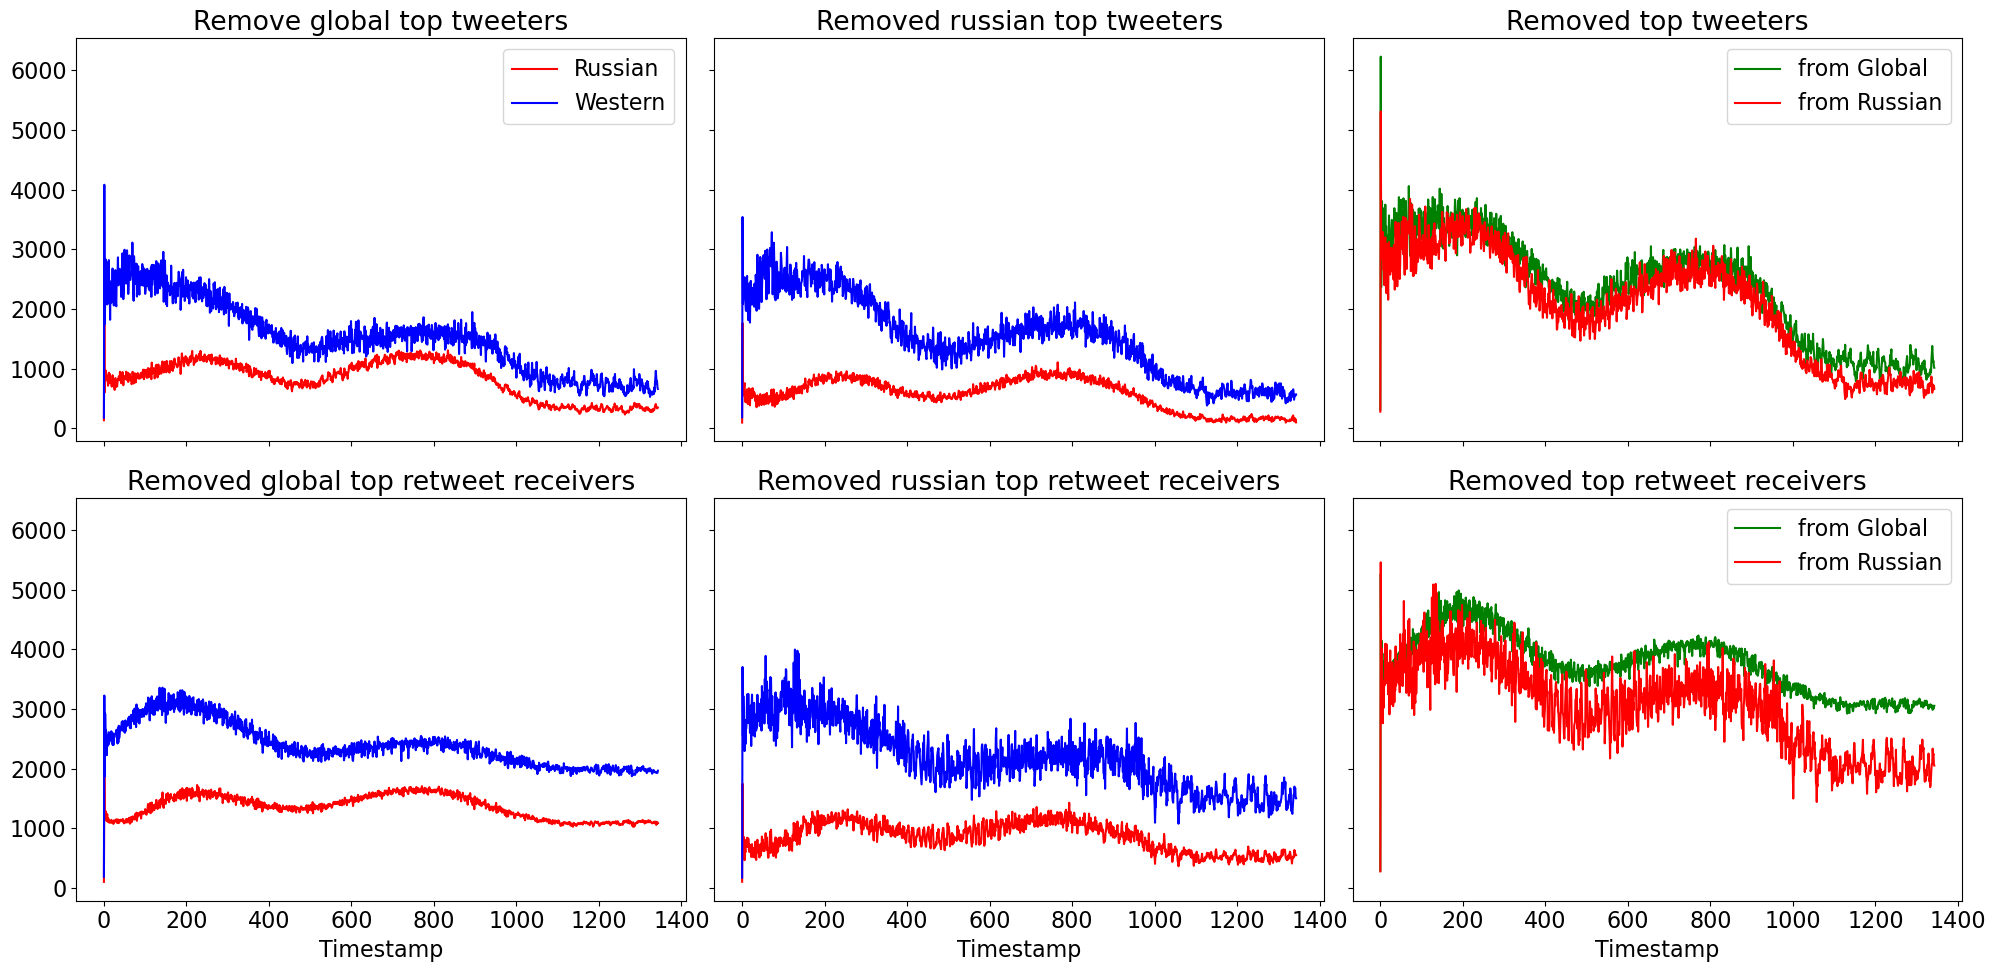

In [33]:
font = {'family' : 'normal',
'weight' : 'bold',
'size' : 25}
plt.rcParams.update({'font.size': 16})

fig, axs = plt.subplots(2,3,sharex=True, sharey=True, figsize=(20,10))

ax = axs[0][0]
dfout2[dfout2["author_id"] < dsim.num_russ_nodes].groupby("timestamp").size().plot(label="Russian",c="red", ax=ax)
dfout2[dfout2["author_id"] > dsim.num_russ_nodes].groupby("timestamp").size().plot(label="Western",c="blue", ax=ax)
ax.legend()
ax.set_title("Remove global top tweeters")

ax = axs[0][1]
dfout3[dfout3["author_id"] < dsim.num_russ_nodes].groupby("timestamp").size().plot(label="russian",c="red", ax=ax)
dfout3[dfout3["author_id"] > dsim.num_russ_nodes].groupby("timestamp").size().plot(label="western",c="blue", ax=ax)
ax.set_title("Removed russian top tweeters")

ax = axs[0][2]
dfout2.groupby("timestamp").size().plot(label="from Global",c="green", ax=ax)
dfout3.groupby("timestamp").size().plot(label="from Russian",c="red", ax=ax)
ax.set_title("Removed top tweeters")
ax.legend()


ax = axs[1][0]
dfout4[dfout4["author_id"] < dsim.num_russ_nodes].groupby("timestamp").size().plot(label="russian",c="red", ax=ax)
dfout4[dfout4["author_id"] > dsim.num_russ_nodes].groupby("timestamp").size().plot(label="western",c="blue", ax=ax)
ax.set_title("Removed global top retweet receivers")
ax.set_xlabel("Timestamp")

ax = axs[1][1]
dfout5[dfout5["author_id"] < dsim.num_russ_nodes].groupby("timestamp").size().plot(label="russian",c="red", ax=ax)
dfout5[dfout5["author_id"] > dsim.num_russ_nodes].groupby("timestamp").size().plot(label="western",c="blue", ax=ax)
ax.set_title("Removed russian top retweet receivers")
ax.set_xlabel("Timestamp")

ax = axs[1][2]
dfout4.groupby("timestamp").size().plot(label="from Global",c="green", ax=ax)
dfout5.groupby("timestamp").size().plot(label="from Russian",c="red", ax=ax)
ax.set_title("Removed top retweet receivers")
ax.set_xlabel("Timestamp")

ax.legend()
plt.tight_layout()
plt.savefig("main_fig.png")
plt.show()

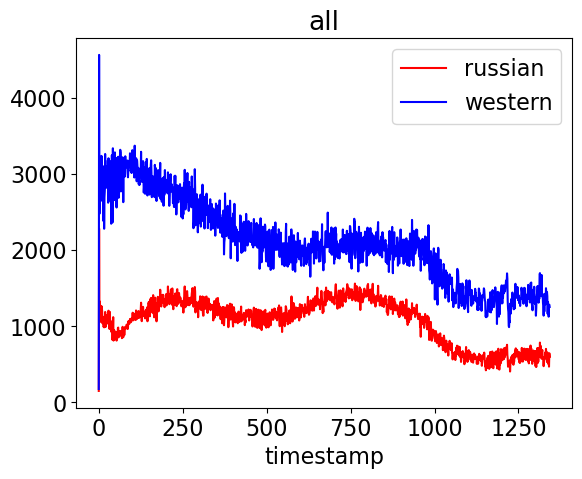

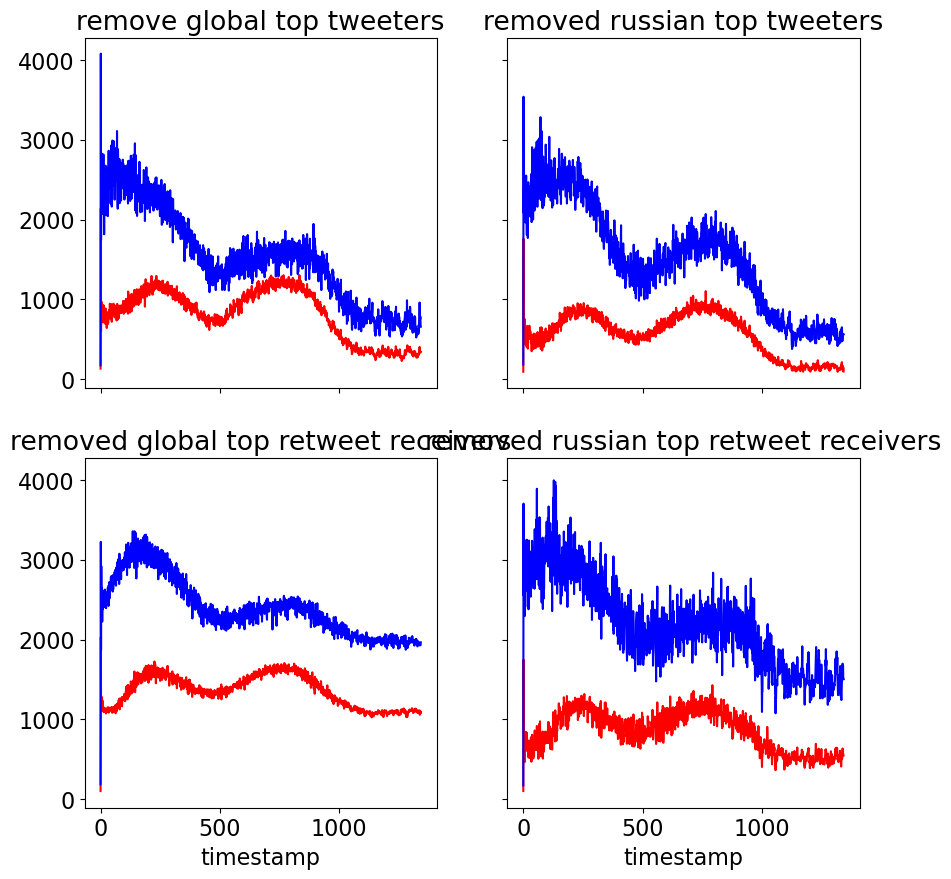

In [34]:
dfout[dfout["author_id"] < dsim.num_russ_nodes].groupby("timestamp").size().plot(label="russian",c="red")
dfout[dfout["author_id"] > dsim.num_russ_nodes].groupby("timestamp").size().plot(label="western",c="blue")
plt.title("all")
plt.legend()
plt.show()

fig, axs = plt.subplots(2,2,sharex=True, sharey=True, figsize=(10,10))

ax = axs[0][0]
dfout2[dfout2["author_id"] < dsim.num_russ_nodes].groupby("timestamp").size().plot(label="russian",c="red", ax=ax)
dfout2[dfout2["author_id"] > dsim.num_russ_nodes].groupby("timestamp").size().plot(label="western",c="blue", ax=ax)
ax.set_title("remove global top tweeters")

ax = axs[0][1]
dfout3[dfout3["author_id"] < dsim.num_russ_nodes].groupby("timestamp").size().plot(label="russian",c="red", ax=ax)
dfout3[dfout3["author_id"] > dsim.num_russ_nodes].groupby("timestamp").size().plot(label="western",c="blue", ax=ax)
ax.set_title("removed russian top tweeters")

ax = axs[1][0]
dfout4[dfout4["author_id"] < dsim.num_russ_nodes].groupby("timestamp").size().plot(label="russian",c="red", ax=ax)
dfout4[dfout4["author_id"] > dsim.num_russ_nodes].groupby("timestamp").size().plot(label="western",c="blue", ax=ax)
ax.set_title("removed global top retweet receivers")

ax = axs[1][1]
dfout5[dfout5["author_id"] < dsim.num_russ_nodes].groupby("timestamp").size().plot(label="russian",c="red", ax=ax)
dfout5[dfout5["author_id"] > dsim.num_russ_nodes].groupby("timestamp").size().plot(label="western",c="blue", ax=ax)
ax.set_title("removed russian top retweet receivers")

plt.show()

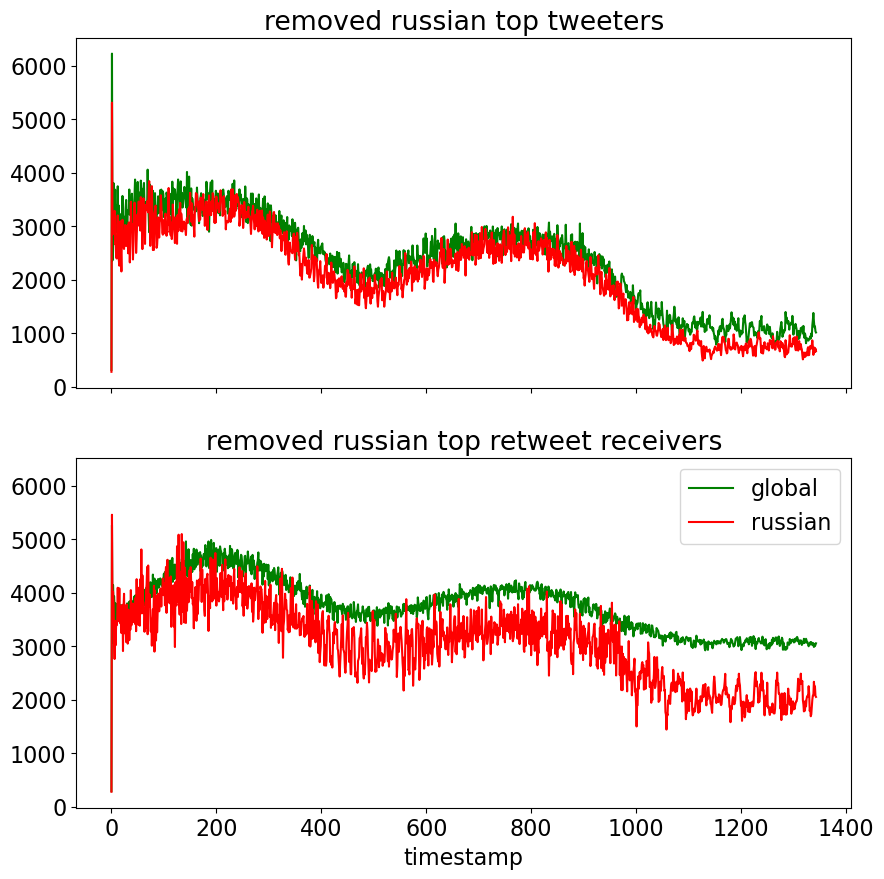

In [35]:

fig, axs = plt.subplots(2,1,sharex=True, sharey=True, figsize=(10,10))

ax = axs[0]
dfout2.groupby("timestamp").size().plot(label="global",c="green", ax=ax)
ax.set_title("remove global top tweeters")

ax = axs[0]
dfout3.groupby("timestamp").size().plot(label="russian",c="red", ax=ax)
ax.set_title("removed russian top tweeters")

ax = axs[1]
dfout4.groupby("timestamp").size().plot(label="global",c="green", ax=ax)
ax.set_title("removed global top retweet receivers")

ax = axs[1]
dfout5.groupby("timestamp").size().plot(label="russian",c="red", ax=ax)
ax.set_title("removed russian top retweet receivers")
plt.legend()
plt.show()

In [36]:
len(dsim.AllMentions)

806400

In [37]:
dsim.run_analytics.keys()

dict_keys(['overload', 'not-overload', 'ovd_rt', 'nonovd_rt', 'tweets'])

In [38]:
dsim.run_analytics["overload"] / (dsim.run_analytics["overload"] + dsim.run_analytics["not-overload"])

0.9986216248274672

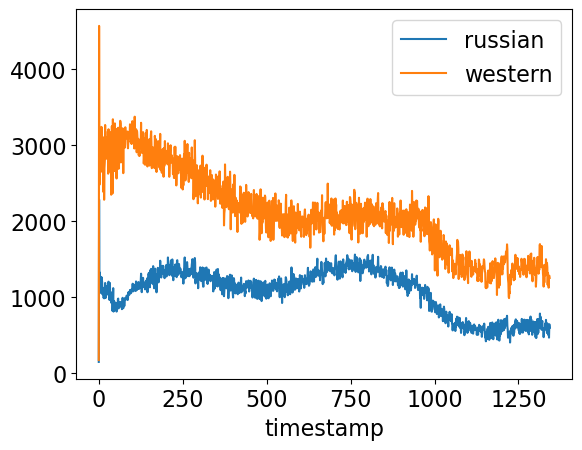

In [39]:
dfout[dfout["author_id"] < dsim.num_russ_nodes].groupby("timestamp").size().plot(label="russian")
dfout[dfout["author_id"] > dsim.num_russ_nodes].groupby("timestamp").size().plot(label="western")
plt.legend()
plt.show()

<Axes: xlabel='timestamp'>

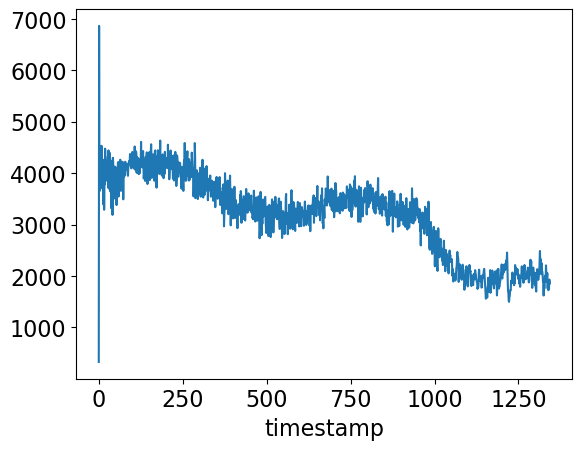

In [40]:
dfout.groupby("timestamp").size().plot()

<Axes: xlabel='timestamp'>

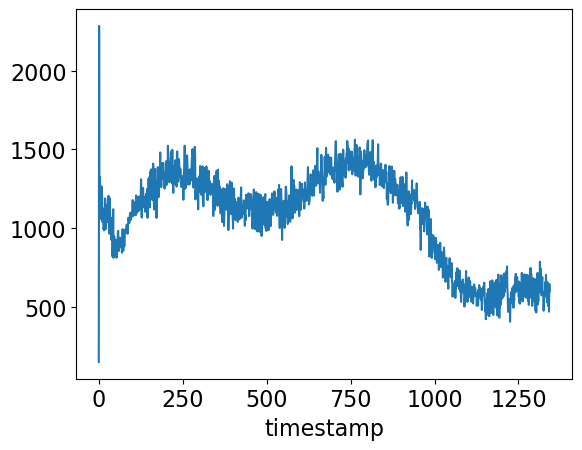

In [41]:
dfout[dfout["author_id"] < dsim.num_russ_nodes].groupby("timestamp").size().plot()

<Axes: xlabel='timestamp'>

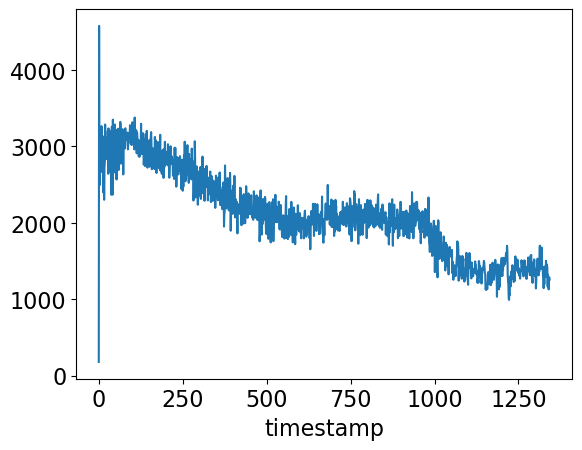

In [42]:
dfout[dfout["author_id"] >= dsim.num_russ_nodes].groupby("timestamp").size().plot()

In [43]:
comp = nx.community.girvan_newman(G)
comp

<generator object girvan_newman at 0x000002038C0EB220>

In [44]:
%%time
import itertools

k = 5
for communities in itertools.islice(comp, k):
    print(tuple(sorted(c) for c in communities))

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221

In [45]:
lvc = nx.community.louvain_communities(G, seed=123)
len(lvc)

3

In [46]:
[len(e) for e in lvc]

[213, 178, 209]

In [ ]:
t = tuple(sorted(c) for c in next(comp))

In [ ]:
[len(e) for e in t]

In [ ]:
dsim.UserMentions

In [ ]:
for widx,wall in enumerate(dsim.UserMentions):
    print(widx, chr(widx + 65))
    for itm in wall:
        it3 = chr(itm[3] + 65) if itm[3] != -1 else "ø"
        it4 = f"M{itm[4]}" if itm[3] != -1 else "ø"
        print(f"M{itm[0]},T{itm[1]},{chr(itm[2] + 65)},{it3},{it4}")